Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - age_loss: 0.3888 - age_mae: 0.5546 - gender_accuracy: 0.7410 - gender_loss: 0.6386 - loss: 1.1053 - val_age_loss: 0.4808 - val_age_mae: 0.6385 - val_gender_accuracy: 0.6250 - val_gender_loss: 0.6841 - val_loss: 1.2555
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - age_loss: 0.3129 - age_mae: 0.4845 - gender_accuracy: 0.8015 - gender_loss: 0.3757 - loss: 0.7645 - val_age_loss: 0.3953 - val_age_mae: 0.5685 - val_gender_accuracy: 0.5625 - val_gender_loss: 0.6748 - val_loss: 1.1576
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - age_loss: 0.2637 - age_mae: 0.4376 - gender_accuracy: 0.9093 - gender_loss: 0.2748 - loss: 0.6133 - val_age_loss: 0.3180 - val_age_mae: 0.4969 - val_gender_accuracy: 0.5625 - val_gender_loss: 0.6677 - val_loss: 1.0699
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - age_loss: 0.1862 - age_mae: 0.3451 - gender_accuracy: 0.8961 - gender_loss: 0.2714 - loss: 0.5308 - val_age_loss: 0.2551 - val_age_mae: 0.4355

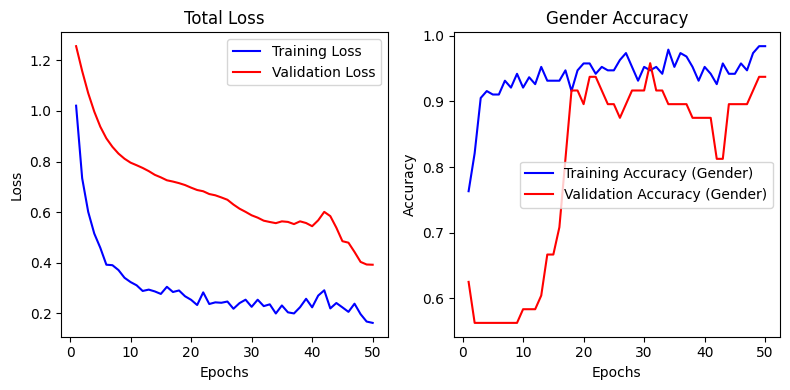

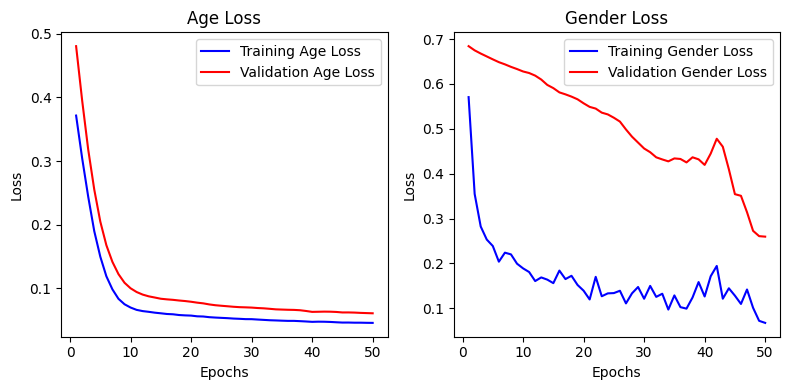

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("Extra4.csv")
data.columns = ["Age", "S", "Gender", "Ca", "Mg", "Zn", "Cu"]

# Encode Gender as binary (0: Female, 1: Male)
label_encoder = LabelEncoder()
data["Gender"] = label_encoder.fit_transform(data["Gender"])  # 0 for F, 1 for M

# Normalize numerical features
scaler = MinMaxScaler()
data[["Age", "S", "Ca", "Mg", "Cu"]] = scaler.fit_transform(data[["Age", "S","Ca", "Mg", "Cu"]])

# Split data into features (X) and targets (y)
X = data[["S", "Ca", "Mg", "Cu"]].values
y_gender = data["Gender"].values  # Gender (binary classification)
y_age = data["Age"].values        # Age (regression)

# Train-test split
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42
)

# Build the model
input_layer = layers.Input(shape=(X_train.shape[1],))

# Shared layer with increased depth
shared_layer = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)

gender_branch = layers.Dense(64, activation='relu')(shared_layer)  # Additional dense layer
gender_branch = layers.BatchNormalization()(gender_branch)  # Batch normalization

gender_branch = layers.Dense(32, activation='relu')(gender_branch)  # Second additional dense layer
gender_branch = layers.BatchNormalization()(gender_branch)  # Batch normalization

gender_branch = layers.Dense(16, activation='relu')(gender_branch)  # Third additional dense layer
gender_branch = layers.BatchNormalization()(gender_branch)  # Batch normalization

# Output layer for Gender
gender_output = layers.Dense(1, activation='sigmoid', name='gender')(gender_branch)
# Age branch (regression)
age_output = layers.Dense(1, activation='linear', name='age')(shared_layer)


# Define the model
model = models.Model(inputs=input_layer, outputs=[age_output, gender_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'age': 'mse', 'gender': 'binary_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy'})

# Train the model
history = model.fit(X_train,
                    {'age': y_age_train, 'gender': y_gender_train},
                    epochs=50, batch_size=32,
                    validation_data=(X_test, {'age': y_age_test, 'gender': y_gender_test}))

# Evaluate the model
loss, age_loss, gender_loss, age_mae, gender_acc = model.evaluate(
    X_test, {'age': y_age_test, 'gender': y_gender_test}
)

print(f"Test loss: {loss}")
print(f"Test Age Loss: {age_loss}, Test Gender Loss: {gender_loss}")
print(f"Test Age MAE: {age_mae}, Test Gender Accuracy: {gender_acc}")

# Predict using the model
y_age_pred, y_gender_pred = model.predict(X_test)

# Post-processing: Converting predictions for gender back to labels (0 for Female, 1 for Male)
y_gender_pred_labels = label_encoder.inverse_transform((y_gender_pred > 0.5).astype(int).flatten())

# Print a few predictions
for i in range(5):
    print(f"Predicted Age: {y_age_pred[i][0]}, Predicted Gender: {y_gender_pred_labels[i]}, Actual Age: {y_age_test[i]}, Actual Gender: {label_encoder.inverse_transform([y_gender_test[i]])[0]}")




import matplotlib.pyplot as plt

# Extract loss and accuracy for both training and validation
epochs = range(1, len(history.history['loss']) + 1)

# Plot total loss
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy for gender
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['gender_accuracy'], 'b', label='Training Accuracy (Gender)')
plt.plot(epochs, history.history['val_gender_accuracy'], 'r', label='Validation Accuracy (Gender)')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot individual losses: Age and Gender
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['age_loss'], 'b', label='Training Age Loss')
plt.plot(epochs, history.history['val_age_loss'], 'r', label='Validation Age Loss')
plt.title('Age Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['gender_loss'], 'b', label='Training Gender Loss')
plt.plot(epochs, history.history['val_gender_loss'], 'r', label='Validation Gender Loss')
plt.title('Gender Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
